In [1]:
import pandas as pd
import numpy as np
import re
from config import *

# Sklearn
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, HDBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

import umap

# Visual
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from itertools import permutations 
from tqdm import tqdm

/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
features = pd.read_parquet(FEATURES_DIR / "features.pq").query("y==1")
features_with_info = features
features = features.drop(["participant_id", "y"], axis=1)
features = features.dropna()
features_stdz = pd.DataFrame(StandardScaler().fit_transform(features.values), columns=features.columns)

In [29]:
def brute_force_cluster_range(clustering_model, X:pd.DataFrame, choose_k: int = 2, n_cluster_min: int = 2, n_cluster_max: int = 10) -> pd.DataFrame:
    """Brute forces by combining n_choose_k features

    Args:
        model (sklearn clustering model): Model must have the n_clusters hyperparameter
        choose_k (int, optional): _description_. Defaults to 2.
        n_cluster_min (int, optional): _description_. Defaults to 2.
        n_cluster_max (int, optional): _description_. Defaults to 10.
        
    Returns:
        pd.DataFrame
    """
    combinations = list(permutations(X.columns, choose_k))

    silhouette_scores = []
    cluster_features = []
    n_clusters = []
    models = []

    for n_cluster in range(n_cluster_min, n_cluster_max):
        
        logging.info(f"n_cluster: {n_cluster}")
        model = clustering_model(n_clusters=n_cluster)
        for combination in tqdm(combinations):
            X_selected_featues = X[list(combination)]
            model.fit(X_selected_featues)
            
            sil_score = silhouette_score(X_selected_featues, model.labels_)

            silhouette_scores.append(sil_score)
            cluster_features.append(list(combination))
            n_clusters.append(n_cluster)
            models.append(model)
    
    df_return = pd.DataFrame({
        'silhouette_scores': silhouette_scores,
        'cluster_features': cluster_features,
        'n_clusters': n_clusters,
        'model': models
    })
    
    return (df_return
     .assign(max_score=df_return.groupby('n_clusters')['silhouette_scores'].transform('max'))
     .query("max_score == silhouette_scores") 
     .drop(columns="max_score")
     .reset_index(drop=True)
    )


model = GaussianMixture(covariance_type='full', reg_covar=1e-3, init_params='k-means++', random_state=42)

df_brute = brute_force_cluster_range(AgglomerativeClustering, features_stdz, n_cluster_min=2,n_cluster_max=11)

2025-05-02 15:20:15,239 - INFO - 2097884040.brute_force_cluster_range:22 - n_cluster: 2
100%|██████████| 2756/2756 [00:02<00:00, 1148.61it/s]
2025-05-02 15:20:17,640 - INFO - 2097884040.brute_force_cluster_range:22 - n_cluster: 3
100%|██████████| 2756/2756 [00:02<00:00, 1105.62it/s]
2025-05-02 15:20:20,134 - INFO - 2097884040.brute_force_cluster_range:22 - n_cluster: 4
100%|██████████| 2756/2756 [00:02<00:00, 1207.15it/s]
2025-05-02 15:20:22,418 - INFO - 2097884040.brute_force_cluster_range:22 - n_cluster: 5
100%|██████████| 2756/2756 [00:02<00:00, 1190.23it/s]
2025-05-02 15:20:24,734 - INFO - 2097884040.brute_force_cluster_range:22 - n_cluster: 6
100%|██████████| 2756/2756 [00:02<00:00, 1151.37it/s]
2025-05-02 15:20:27,129 - INFO - 2097884040.brute_force_cluster_range:22 - n_cluster: 7
100%|██████████| 2756/2756 [00:02<00:00, 1218.40it/s]
2025-05-02 15:20:29,392 - INFO - 2097884040.brute_force_cluster_range:22 - n_cluster: 8
100%|██████████| 2756/2756 [00:02<00:00, 1229.98it/s]
2025-0

In [32]:
def add_features_to_cluster_model(df: pd.DataFrame, X: pd.DataFrame, clustering_model, patience: int = 0) -> pd.DataFrame:
    chosen_features = []
    chosen_n_clusters = []
    chosen_silhouette_scores = []
    chosen_models = []
    chosen_n_features = []
    
    for i, (brute_force_sil_score, brute_force_features, n_cluster, brute_force_model) in df.iterrows():
        logging.info(f"Testing for {n_cluster} clusters")
        logging.info(f"Score to beat: {brute_force_sil_score}")
        logging.info(f"Model starts with features {brute_force_features}")
        
        best_overall_features = brute_force_features
        best_overall_sil_score = brute_force_sil_score
        best_overall_model = brute_force_model

        features_to_test = X.copy()
        features_to_test = features_to_test.drop(best_overall_features, axis=1).columns.to_list()
        n_features_left_to_test = len(features_to_test)
        
        best_features = best_overall_features.copy()
        logging.info(f"Best features now contain {best_features}")
        logging.info(f"Best overall features now contain {best_overall_features}")
        
        patience_counter = 0

        while (n_features_left_to_test > 0) and (patience_counter <= patience):
            logging.info(f"FSC: {patience_counter}")
            best_sil_score = 0
            best_feature_added = None
            best_model = None
            for feature in features_to_test:
                feature_to_test_including_brute = list(np.unique([feature] + brute_force_features))
                X_select: pd.DataFrame = X[feature_to_test_including_brute]
                
                model = clustering_model(n_clusters = n_cluster)
                model.fit(X_select)
                
                sil_score = silhouette_score(X_select, model.labels_)
                
                if best_sil_score < sil_score:
                    logging.info(f"New best sil score: {best_sil_score} -> {sil_score}")
                    best_sil_score = sil_score
                    best_feature_added = feature
                    best_model = model
                
            logging.info(f"New best feature added: {best_feature_added}")
            best_features += [best_feature_added]
            features_to_test.remove(best_feature_added)
            n_features_left_to_test = len(features_to_test)

            if best_overall_sil_score < best_sil_score:
                logging.info(f"New best overall sil score: {best_overall_sil_score} -> {best_sil_score}")
                best_overall_sil_score = best_sil_score
                best_overall_features = best_features
                best_overall_model = best_model
            logging.info(f"Best features now contain {best_features}")
            logging.info(f"Best overall features now contain {best_overall_features}")
            patience_counter += 1
        
        
        chosen_features.append(best_overall_features)
        chosen_n_clusters.append(n_cluster)
        chosen_silhouette_scores.append(best_overall_sil_score)
        chosen_models.append(best_overall_model)
        chosen_n_features.append(len(best_overall_features))
    
    


    df_return = pd.DataFrame({
        'chosen_features': chosen_features, 
        'chosen_n_clusters': chosen_n_clusters,
        'chosen_silhouette_scores': chosen_silhouette_scores,
        'chosen_models':chosen_models,
        'chosen_n_features': chosen_n_features
    })    
        
    return df_return

df_added_features = add_features_to_cluster_model(df=df_brute,
                              X=features_stdz,
                              clustering_model=AgglomerativeClustering,
                              patience=10)

2025-05-02 15:21:31,617 - INFO - 3339072486.add_features_to_cluster_model:9 - Testing for 2 clusters
2025-05-02 15:21:31,618 - INFO - 3339072486.add_features_to_cluster_model:10 - Score to beat: 0.8697780082226968
2025-05-02 15:21:31,619 - INFO - 3339072486.add_features_to_cluster_model:11 - Model starts with features ['ANTI_SACCADE_Var_total', 'SMOOTH_PURSUITS_duration_std_sacc']
2025-05-02 15:21:31,619 - INFO - 3339072486.add_features_to_cluster_model:22 - Best features now contain ['ANTI_SACCADE_Var_total', 'SMOOTH_PURSUITS_duration_std_sacc']
2025-05-02 15:21:31,620 - INFO - 3339072486.add_features_to_cluster_model:23 - Best overall features now contain ['ANTI_SACCADE_Var_total', 'SMOOTH_PURSUITS_duration_std_sacc']
2025-05-02 15:21:31,620 - INFO - 3339072486.add_features_to_cluster_model:28 - FSC: 0
2025-05-02 15:21:31,623 - INFO - 3339072486.add_features_to_cluster_model:42 - New best sil score: 0 -> 0.7486885622057355
2025-05-02 15:21:31,628 - INFO - 3339072486.add_features_to_c

In [14]:

def plot_scatter_of_clusters(X, clustering_model = None, reducer=None, labels=None):
    coeff = None
    n_features_provided = X.shape[1]
    if reducer is not None and n_features_provided > 2:
        X_reduced = reducer.fit_transform(X)
        if "PCA" in reducer.__str__():
            coeff = reducer.components_
        X_reduced_df = pd.DataFrame({"Component 1": X_reduced[:,0]
                                ,'Component 2': X_reduced[:,1]})
    else:
        if n_features_provided != 2:
            raise ValueError('Dimensionality reduction method must be provided when number of features are not 2')
        X_reduced_df = X

    x_var_name, y_var_name = X_reduced_df.columns

    if clustering_model is not None:
        X_reduced_df["cluster"] = clustering_model.labels_ 

        sns.scatterplot(X_reduced_df, x=x_var_name, y=y_var_name, hue='cluster')
    else:
        sns.scatterplot(X_reduced_df, x=x_var_name, y=y_var_name)
    
    if coeff is not None:
        print(coeff.shape)
        n = coeff.shape[1]
        for i in range(n):
#            if np.abs(coeff[0, i]) > 0.15 and np.abs(coeff[1,i]) > 0.15:
                plt.arrow(0, 0, coeff[0,i]*5, coeff[1,i]*5,color = 'r',alpha = 0.5)
                if labels is None:
                    plt.text(coeff[0,i]* 5, coeff[1,i] * 5, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
                else:
                    print(labels[i])
                    plt.text(coeff[0,i]* 5, coeff[1,i] * 5, labels[i], color = 'g', ha = 'center', va = 'center')
            # else:
            #     if labels is None:
            #         logging.info(f"Excluded variable {i}")
            #     else:
            #         logging.info(f"Excluded {labels[i]}")    
                

In [15]:
chosen_features_df

,features,n_features,silhouette_scores,n_clusters,model
0,"[EVIL_BASTARD_distance_to_fixpoint_x_max, EVIL...",2,0.569524,3,HDBSCAN()
1,"[FITTS_LAW_duration_std_sacc, FITTS_LAW_peak_v...",2,0.768208,3,HDBSCAN()
2,"[REACTION_x_acceleration_max, FITTS_LAW_peak_v...",2,0.624946,3,HDBSCAN()
3,"[ANTI_SACCADE_duration_std_fix, FITTS_LAW_peak...",2,0.472148,3,HDBSCAN()
4,"[KING_DEVICK_x_acceleration_std, ANTI_SACCADE_...",5,0.492026,3,HDBSCAN()


In [36]:
idx = 1
n_clusters_plot = chosen_features_df["n_clusters"].iloc[idx]
model_plot = chosen_features_df["model"].iloc[idx]
features_to_plot = list(chosen_features_df["features"].iloc[idx])
plot_df = features_stdz[features_to_plot]

plot_df


,FITTS_LAW_duration_std_sacc,FITTS_LAW_peak_velocity_min_sacc
0,-0.399880,1.035636
1,-0.302350,-0.080640
2,-0.453511,1.086376
3,0.203139,0.781937
4,-0.401583,0.477498
5,-0.307080,0.731197
6,-0.155279,-1.298396
7,-0.317133,0.731197
8,-0.216589,0.528238
9,-0.184958,-0.943217


/var/folders/v0/l_dtghc15651j6_9p3clc_r00000gt/T/ipykernel_33428/3286281683.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_reduced_df["cluster"] = clustering_model.labels_


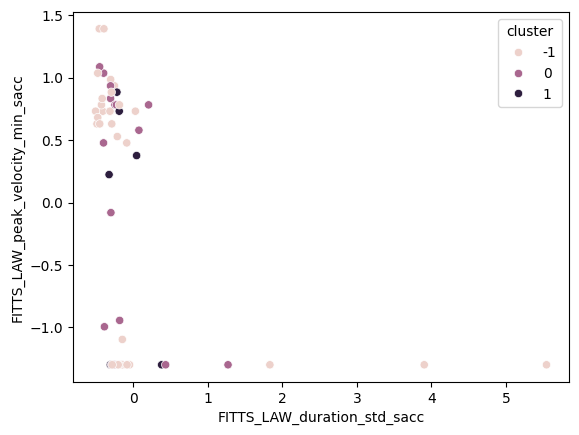

In [37]:

plot_scatter_of_clusters(X=plot_df
                         , clustering_model=model_plot
                         , reducer=PCA(n_components=2)
                         , labels=None)


In [32]:
plot_df

,FITTS_LAW_duration_std_sacc,FITTS_LAW_peak_velocity_min_sacc
0,-0.399880,1.035636
1,-0.302350,-0.080640
2,-0.453511,1.086376
3,0.203139,0.781937
4,-0.401583,0.477498
5,-0.307080,0.731197
6,-0.155279,-1.298396
7,-0.317133,0.731197
8,-0.216589,0.528238
9,-0.184958,-0.943217


/var/folders/v0/l_dtghc15651j6_9p3clc_r00000gt/T/ipykernel_33428/3286281683.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_reduced_df["cluster"] = clustering_model.labels_


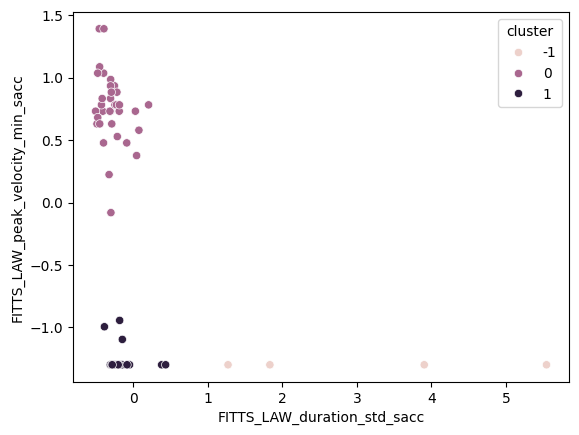

In [33]:


model = HDBSCAN()

model.fit(plot_df)

plot_scatter_of_clusters(X=plot_df
                         , clustering_model=model
                         , reducer=PCA(n_components=2)
                         , labels=plot_df.columns)



In [ ]:

# HDBSCAN only

column_combinations = list(permutations(features_stdz.columns, 2))
silhouette_scores = []
silhouette_features = []
n_clusters = []
models = []

model = HDBSCAN()

for col_comb in tqdm(column_combinations):
    X = features_stdz[list(col_comb)]

    model.fit(X)
    n_predicted_clusters = len(np.unique(model.labels_))
    if n_predicted_clusters == 1:
        continue
    sil_score = silhouette_score(X, model.labels_)
    # sil_score = silhouette_score(X, model.predict(X))
    silhouette_scores.append(sil_score)
    silhouette_features.append(X.columns.to_list())
    n_clusters.append(n_predicted_clusters)
    models.append(model)
    